## Section 4.2.1 Representing a function with basis expansions

The following objects are masked from engine (pos = 3):

    size, wear



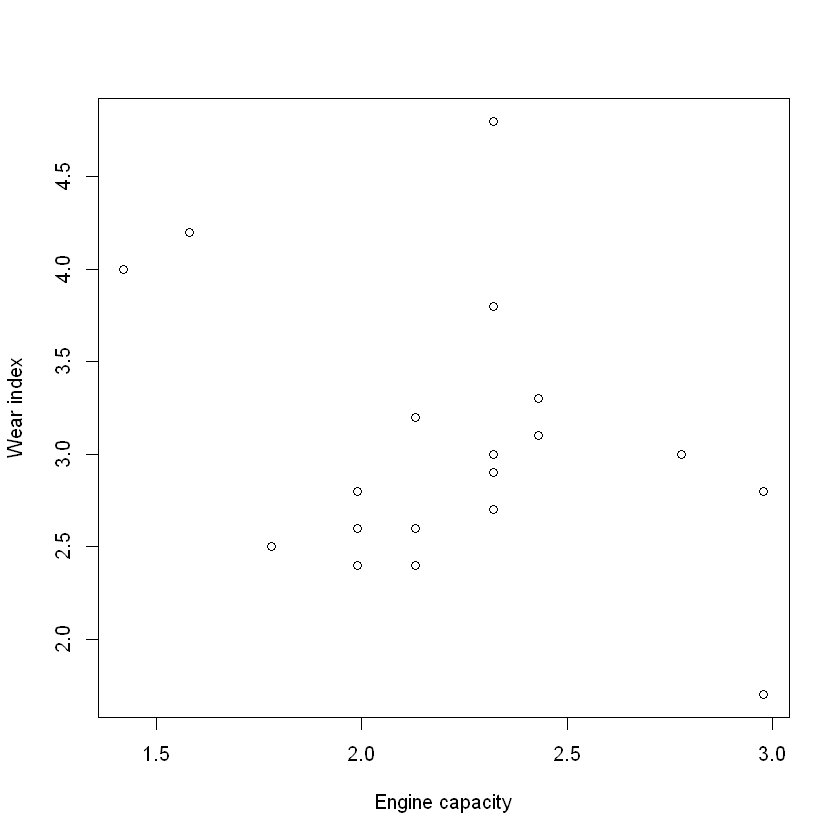

In [3]:
require(gamair)
data(engine)
attach(engine)
plot(size, wear, xlab="Engine capacity", ylab="Wear index")

In [4]:
tf <- function(x, xj, j){
    ## generate the jth tent function from set defined by knots xj
    dj <- xj*0
    dj[j] <- 1
    approx(xj, dj, x)$y
}

In [5]:
tf.X <- function(x, xj){
    ## tent function basis matrix given data x
    ## and knot sequence xj
    nk <- length(xj)
    n <- length(x)
    X <- matrix(NA, n, nk)
    for (j in 1:nk) X[,j] <- tf(x, xj, j)
    X
}

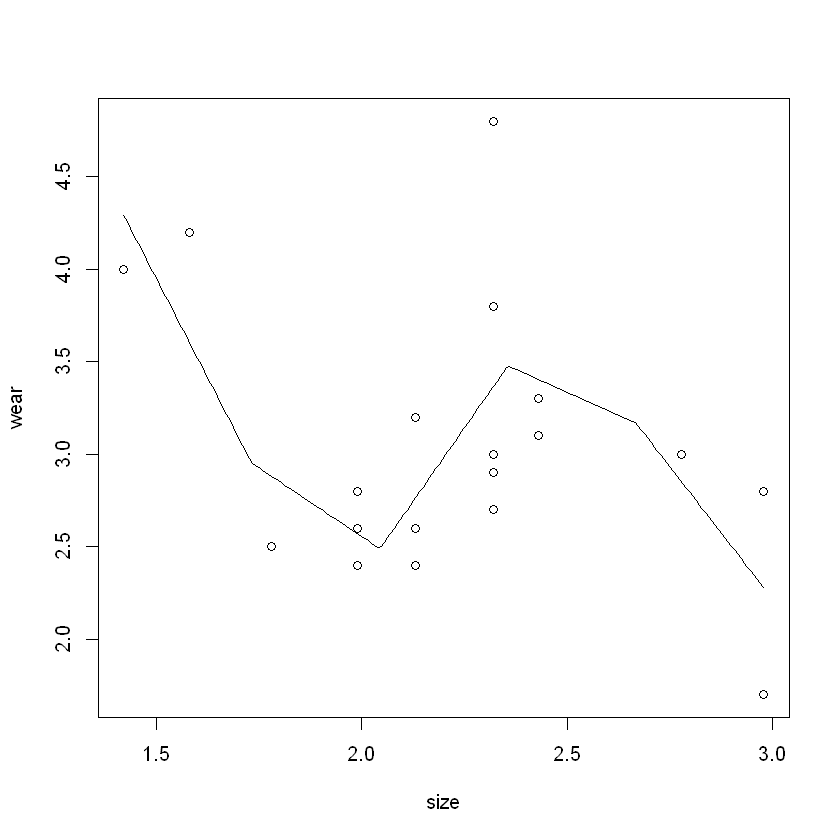

In [6]:
sj <- seq(min(size), max(size), length=6) # generate knots
X <- tf.X(size, sj) # get model matrix
b <- lm(wear ~ X - 1) # git model 
s <- seq(min(size), max(size), length=200) #prediction data
Xp <- tf.X(s, sj) # prediction matrix
plot(size, wear) # plot data overlay
lines(s, Xp %*% coef(b)) # estimated f

## Section 4.2.2 Controlling Smoothness by Penalizing Wiggliness

Simple function for fitting a penalized piecewise linear smoother. Provided that the number of knots is large enough that the basis is more glexible than we expect to need to represent f(x), then neither the exact choice of k, nor the precise selection of knot locations, has a great deal of influence on the model fit. Rather it is the choice of lambda that now plays the crucial role in determining model flexibility.

In [7]:
prs.fit <- function(y, x, xj, sp) {
    X <- tf.X(x, xj)   ## model matrix
    D <- diff(diag(length(xj)), differences=2)   ## sqrt penalty
    X <- rbind(X, sqrt(sp)*D)   ## augmented model matrix
    y <- c(y, rep(0, nrow(D)))   ## augmented data
    lm(y ~ X - 1)   ## penalized least squares fit
}

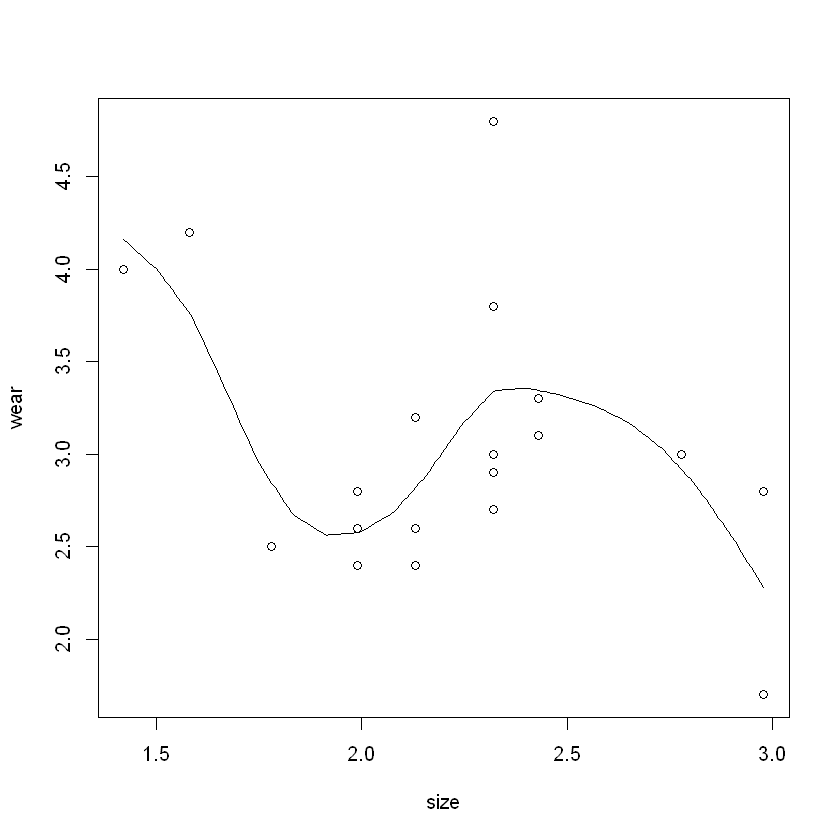

In [8]:
sj <- seq(min(size), max(size), length=20)   ## knots
b <- prs.fit(wear, size, sj, 2)   ## penalized fit
plot(size, wear)   ## plot data
Xp <- tf.X(s, sj)   ## prediction matrix
lines(s, Xp %*% coef(b))   ## plot the smooth

**Takeaway:** By changing the value of the smoothing parameter (lambda), a variety of models of different smoothness can be obtained. It begs the question, which value of lambda is "best"? 

*Section 4.2.3 "Choosing the smoothing parameter, lambda, by cross validation", which we have skipped for now*

## Section 4.3.1 Penalized piecewise regression representation of an additive model

The fact that the model now contains more than one function introduces an identifiability problem: f1 and f2 are each only estimable to within an additive constant. The below function produces constrained versions of Xj and Dj to satisty the identifiability constraint.

In [9]:
tf.XD <- function(x, xk, cmx=NULL, m=2) {
    ## get X and D subject to constraint
    nk <- length(xk)
    X <- tf.X(x, xk)[,-nk]   ## basis matrix
    D <- diff(diag(nk), differences=m)[,-nk]   ## root penalty
    if (is.null(cmx)) cmx <- colMeans(X)
    x <- sweep(X, 2, cmx)   ## subtract cmx from columns
    list(X=X, D=D, cmx=cmx)
}

td.XD calls the functions producing the unconstrained basis and square root penalty matrices, given knot sequence xk and covariate values x. It drops a column of each resulting matrix and centers the remaining columns of the basis matrix. cmx is the vector of values to subtract from the columns of the X. For setting up a basis cmx should be NULL, in which case it is set to the column means of the basis matrix x. However, when using tf.XD to produce a basis matrix for predicting at new covariate values, it is essential that the basis matrix columns are centered using the same constants used for the original basis setup, so these must be supplied. Later code will clarify this.

## Section 4.3.2 Fitting additive models by penalized least squares

Here is a function to set up and fit a simple two term additive model, assuming the same number of knots for each smooth

In [10]:
am.fit <- function(y, x, v, sp, k=10) {
    ## setup bases and penalties...
    xk <- seq(min(x), max(x), length=k)
    xdx <- tf.XD(x, xk)
    vk <- seq(min(v), max(v), length=k)
    xdv <- tf.XD(v, vk)
    ## create augmented model matrix and response
    nD <- nrow(xdx$D)*2
    sp <- sqrt(sp)
    X <- cbind(c(rep(1,nrow(xdx$X)), rep(0, nD)),
              rbind(xdx$X, sp[1]*xdx$D, xdv$D*0),
              rbind(xdv$X, xdx$D*0, sp[2]*xdv$D))
    y1 <- c(y, rep(0, nD))
    ## fit the model
    b <- lm(y1 ~ X - 1)
    ## compute some useful quantities
    n <- length(y)
    trA <- sum(influence(b)$hat[1:n])   ## EDF
    rsd <- y - fitted(b)[1:n] ## residuals
    rss <- sum(rsd^2)   ## residual SS
    sig.hat <- rss/(n-trA)   ## residual variance
    gcv <- sig.hat*n/(n-trA)   ## GCV score
    Vb <-vcov(b)*sig.hat/summary(b)$sigma^2   ## coeff cov matrix
    ## return fitted model
    list(b=coef(b), Vb=Vb, edf=trA, gcv=gcv, fitted=fitted(b)[1:n],
        rsd=rsd, xk=list(xk, vk),cmx=list(xdx$cmx,xdv$cmx))
}



In addition to the quantities that we met in the single smooth case, am.fit also returns an estimate of the Bayesian covariance matrix (?) for the model coefficients.

Let us use the routine to estimate an additive model for the data in R data frame trees. The data are Volume, Girth, and Height for 31 felled cherry trees. Interest lies in predicting Volume, and we can try estimating the model

**Volume = alpha + f1(Firth) + f2(Height) + e**

In [11]:
am.gcv <- function(lsp, y, x, v, k) {
    ## function suitable for GCV optimization by optim
    am.fit(y, x, v, exp(lsp), k)$gcv
}

Using log smoothing parameters for optimization ensures that the estimated smoothing parameters are non-negative. Fitting the model is now straightforward

In [12]:
## find GCV optimal smoothing parameters...
fit <- optim(c(0,0), am.gcv, y=trees$Volume, x=trees$Girth,
            v=trees$Height,k=10)
sp <- exp(fit$par)   ## best fit smoothing parameters
## Get fit at GCV optimal smoothing parameters...
fit <- am.fit(trees$Volume, trees$Girth, trees$Height,sp,k=10)

Now let's plot the smooth effects. The following function will do this:

In [13]:
am.plot <- function(fit,xlab,ylab) {
    ## produces effect plots for simple 2 term
    ## additive model
    start <- 2   ## where smooth soeffs start in beta
    for (i in 1:2) {
        ## sequence of values at which to predict...
        x <- seq(min(fit$xk[[i]]), max(fit$xk[[i]]), length=200)
        ## get prediction matrix for this smooth...
        Xp <- tf.XD(x, fit$xk[[i]], fit$cmx[[i]])$X
        ## extract coefficients and cov matrix for this smooth
        stop <- start + ncol(Xp)-1; ind <- start:stop
        b <- fit$b[ind];Vb <-fit$Vb[ind,ind]
        ##values for smooth at x...
        fv <- Xp %*% b
        ## standard errors of smooth at x...
        se <-rowSums((Xp %*% Vb) * Xp)^.5
        ## 2 s.e. limits for smooth...
        ul <- fv + 2 * se; ll <- fv - 2 * se
        ## plot smooth and limits...
        plot(x, fv, type="l", ylim=range(c(ul,ll)), xlab=xlab[i], ylab=ylab[i])
        lines(x, ul, lty=2); lines(x, ll, lty=2)
        start <- stop + 1
    }
}

Calling it with the fitted tree model

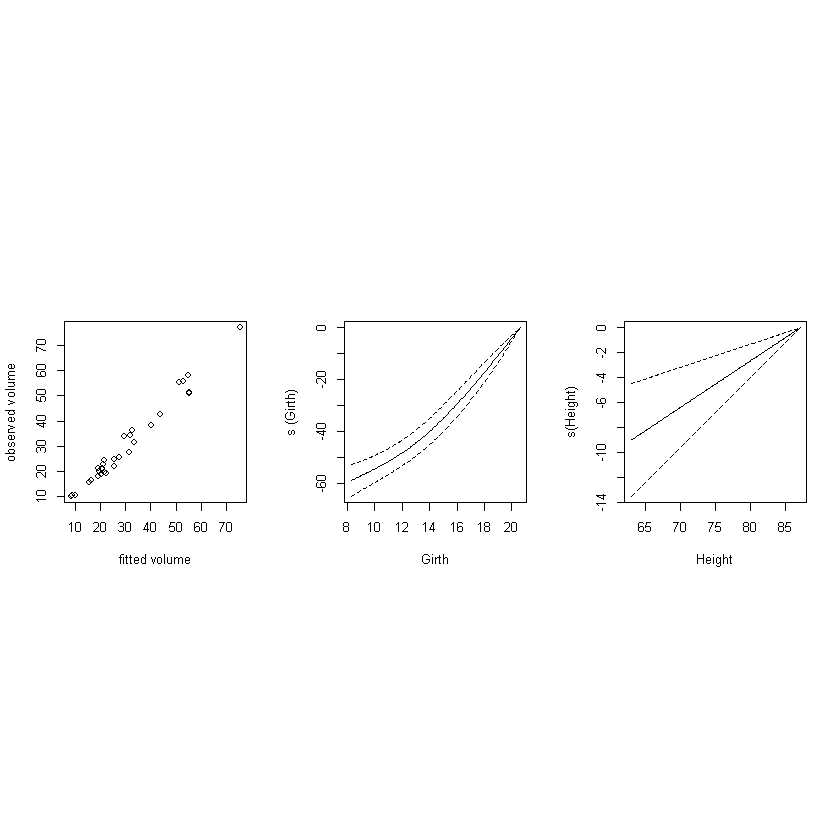

In [14]:
par(mfrow=c(1, 3), pty="s")
plot(fit$fitted, trees$Vol, xlab="fitted volume" , ylab="observed volume")
am.plot(fit, xlab=c("Girth", "Height"),
       ylab=c("s (Girth)", "s(Height)"))

Notice that the smooth of Height is estimated to be a straight line, and as a result its condifence interval has zerp width at some point. The zero width point in the interval occurs because the sum to zero constraint exactly determines where the straight line must pass through zero. As with the one dimensional smooth, the additive model could also be estimated as a linear mixed model, but let us move on.

## Section 4.4 Generalized additive models

The following function implements the PIRLS loop for the log-gamma model, and returns the required GCV score in its return list

In [15]:
gam.fit <- function(y, x, v, sp, k=10) {
    ## gamma error log link 2 term gam fit...
    eta <- log(y)   ## get initial eta
    not.converged <- TRUE
    old.gcv <- -100 ## don't converge immediately
    while (not.converged) {
        mu <- exp(eta)   ## current mu estimate
        z <- (y - mu)/mu + eta   ## pseudodata
        fit <- am.fit(z, x, v, sp, k)   ## penalized least squares
        if (abs(fit$gcv-old.gcv)<1e-5*fit$gcv) {
            not.converged <- FALSE
        
        }
        old.gcv <- fit$gcv
        eta <- fit$fitted  ## update eta
    }
    fit$fitted <- exp(fit$fitted)   ## mu
    fit
    
}

A simple wrapper is needed in order to optimize the GCV score using optim

In [16]:
gam.gcv <- function(lsp, y, x, v, k=10) {
    gam.fit(y, x, v, exp(lsp), k=k)$gcv
}

Now fitting and plotting proceeds exactly as in the simple additive case.

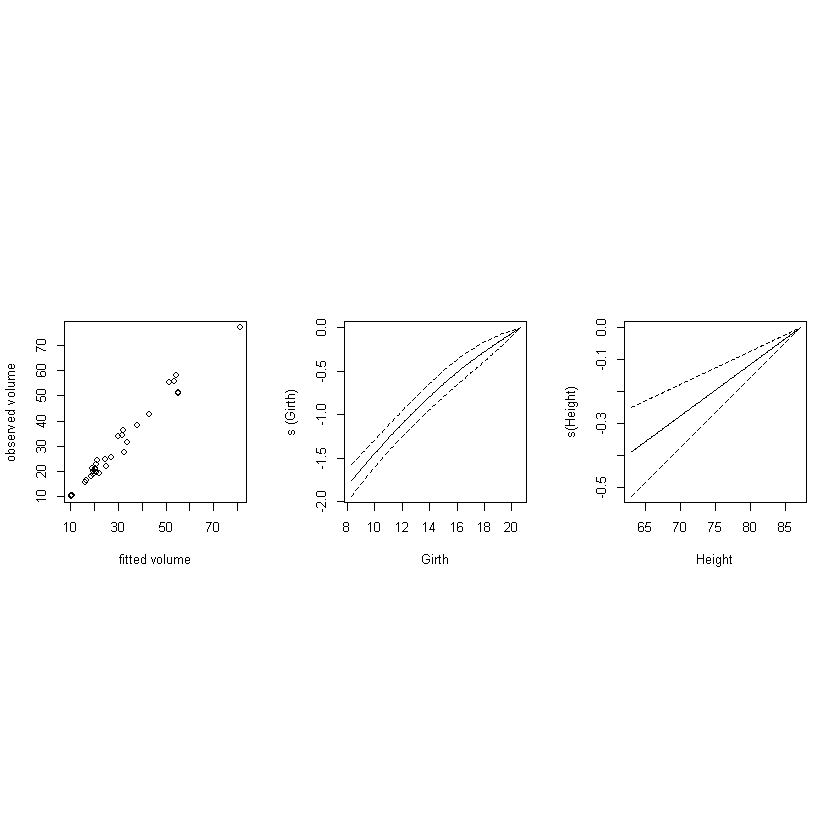

In [17]:
fit <- optim(c(0,0),gam.gcv,y=trees$Volume,x=trees$Girth, v=trees$Height,k=10)
sp <- exp(fit$par)
fit <- gam.fit(trees$Volume, trees$Girth,trees$Height,sp); par(mfrow=c(1,3), pty="s")
plot(fit$fitted,trees$Vol,xlab="fitted volume", ylab="observed volume")
am.plot(fit, xlab=c("Girth", "Height"), ylab=c("s (Girth)", "s(Height)"))

## Section 4.6 Introducing package mgcv

In [19]:
library(mgcv)   ## load the package
data(trees)
ct1 <- gam(Volume ~ s(Height) + s(Girth), family=Gamma(link=log), data=trees)

Loading required package: nlme
This is mgcv 1.8-24. For overview type 'help("mgcv-package")'.

Attaching package: 'mgcv'

The following object is masked _by_ '.GlobalEnv':

    gam.fit



In [20]:
ct1


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height) + s(Girth)

Estimated degrees of freedom:
1.00 2.42  total = 4.42 

GCV score: 0.008082356     

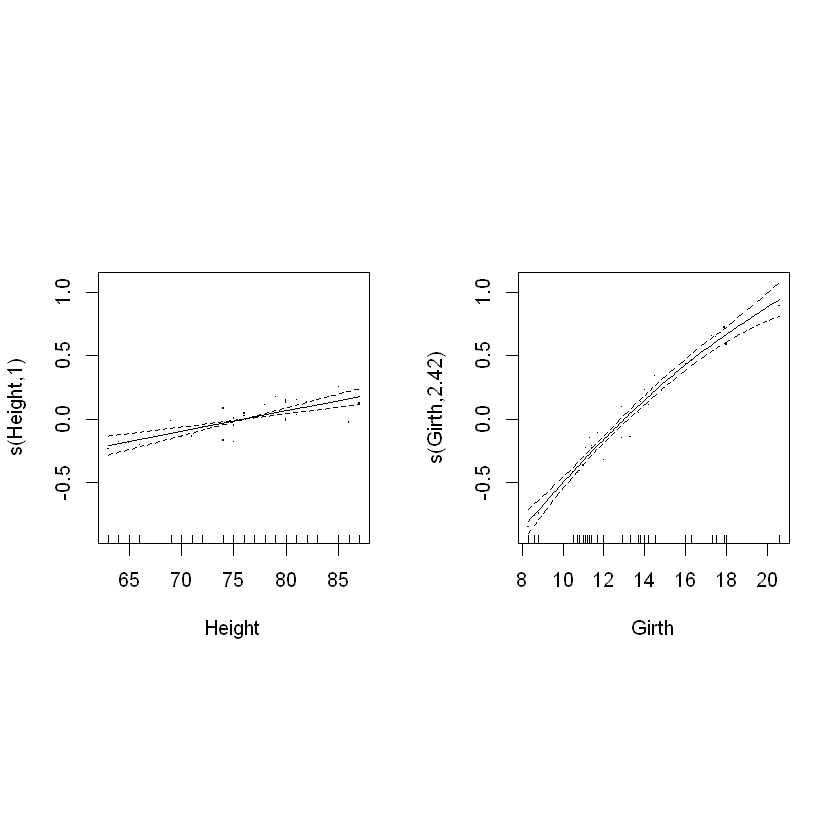

In [21]:
par(mfrow=c(1,2), pty="s")
plot(ct1, residuals=TRUE)

ct1 uses the default settings for gam

## Section 4.6.1 Finer control of gam

In [22]:
ct2 <- gam(Volume ~ s(Height, bs="cr") + s(Girth, bs="cr"), family=Gamma(link=log), data=trees)

In [23]:
ct2


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height, bs = "cr") + s(Girth, bs = "cr")

Estimated degrees of freedom:
1.00 2.42  total = 4.42 

GCV score: 0.008080514     

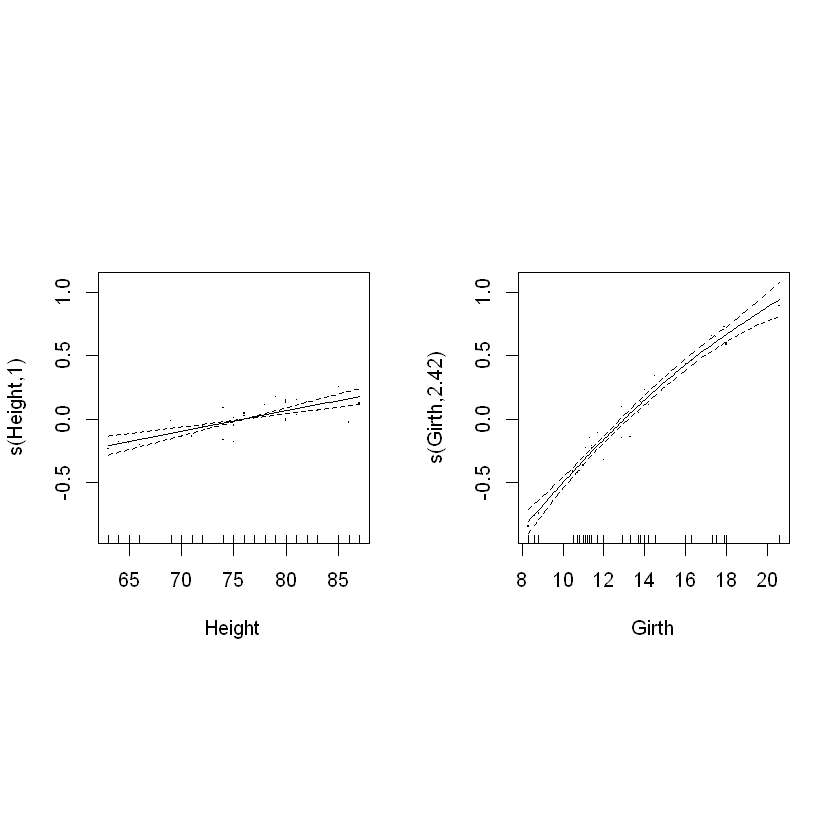

In [24]:
par(mfrow=c(1,2), pty="s")
plot(ct2, residuals=TRUE)

ct2 uses penalized cubic regression splines instead of the default thin plate regression spline (changes the basis)

In [26]:
ct3 <- gam(Volume ~ s(Height) + s(Girth, bs="cr", k=20), family=Gamma(link=log), data=trees)

In [27]:
ct3


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height) + s(Girth, bs = "cr", k = 20)

Estimated degrees of freedom:
1.00 2.42  total = 4.42 

GCV score: 0.008082974     

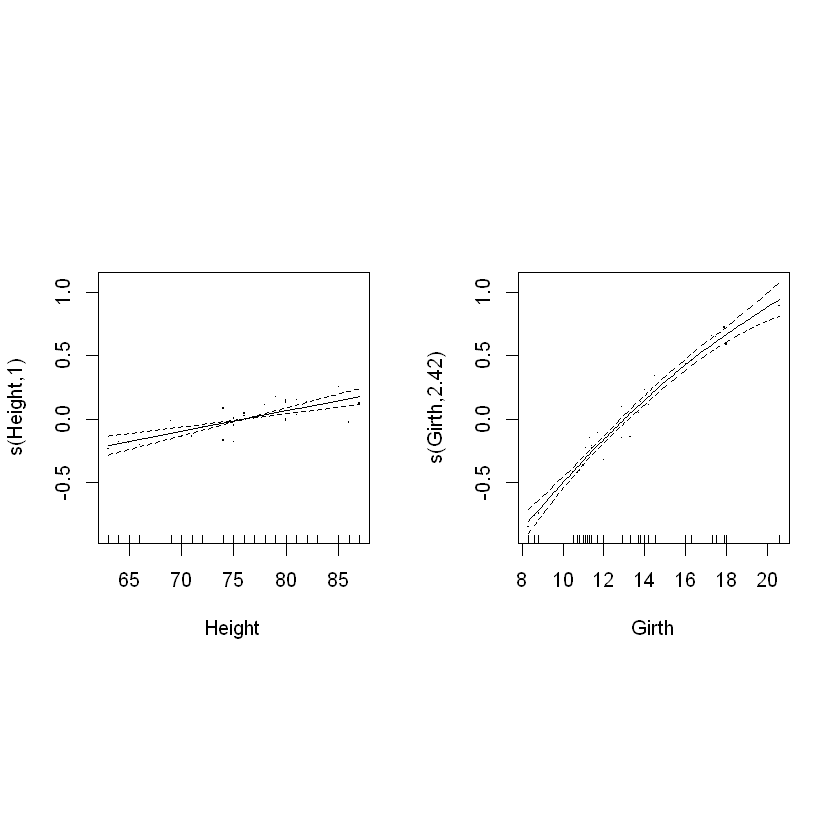

In [28]:
par(mfrow=c(1,2), pty="s")
plot(ct3, residuals=TRUE)

ct3 changed degrees of freedom to 20. Does k refer to degrees of freedom? Are degrees of freedom the same as knots in this context?

In [29]:
ct4 <- gam(Volume ~ s(Height) + s(Girth), family=Gamma(link=log),data=trees,gamma=1.4)

In [30]:
ct4


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height) + s(Girth)

Estimated degrees of freedom:
1.00 2.17  total = 4.17 

GCV score: 0.009228008     

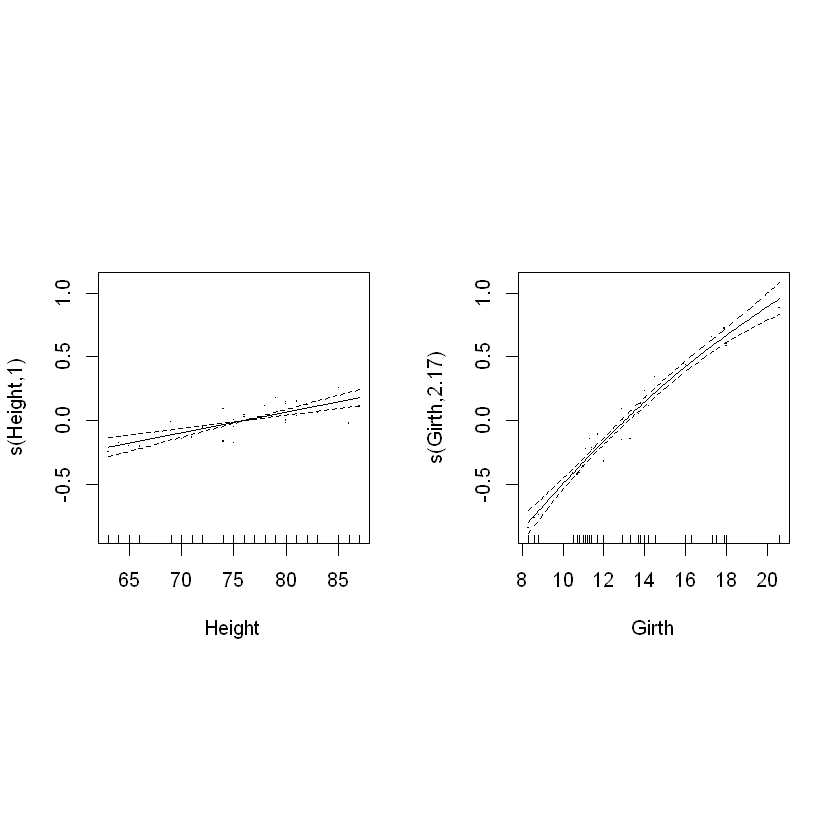

In [31]:
par(mfrow=c(1,2), pty="s")
plot(ct4, residuals=TRUE)

ct4 sets gamma to 1.4, as opposed to the default values of 1. This will put a heavier penalty on each degree of freedom, which resulted in a model with fewer degrees of freedom, but the figure indicates that the change in estimates that this produces is barely perceptible.

## 4.6.2 Smooths of several variables

`gam` is not restricted to models containing only smooths of one predictor. Smooths of any number of predictors are possible via two types of smooth. Within a model foruma, s() terms, using the "tp", "ds", or "gp" bases, produce isotropic smooths of multiple predictors

In [32]:
ct5 <- gam(Volume ~ s(Height, Girth, k=25), family=Gamma(link=log), data=trees)

In [33]:
ct5


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height, Girth, k = 25)

Estimated degrees of freedom:
4.79  total = 5.79 

GCV score: 0.009357594     

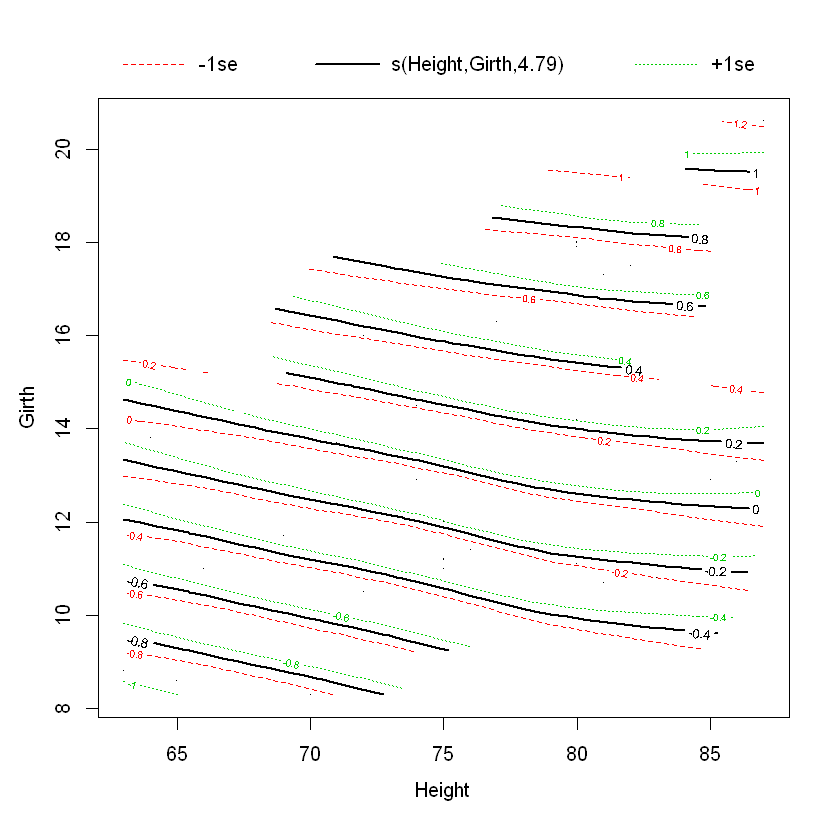

In [36]:
plot(ct5, too.far=0.15)

ct5 uses an isotropic thin plate regression spline

In [39]:
ct6 <- gam(Volume ~ te(Height, Girth, k=5), family=Gamma(link=log),data=trees)

In [40]:
ct6


Family: Gamma 
Link function: log 

Formula:
Volume ~ te(Height, Girth, k = 5)

Estimated degrees of freedom:
3  total = 4 

GCV score: 0.008197078     

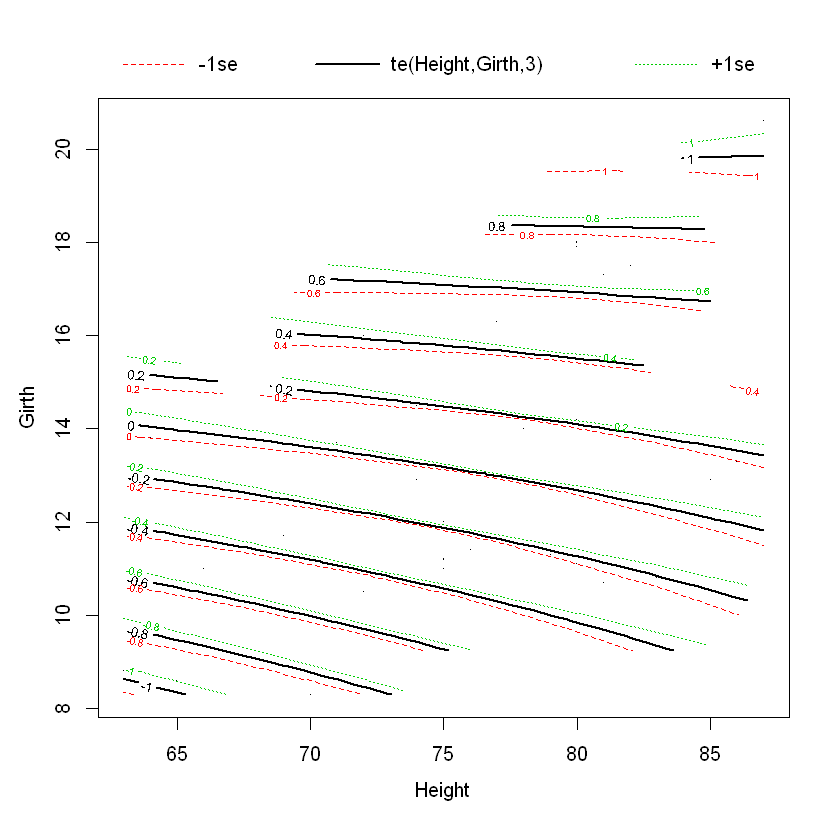

In [41]:
plot(ct6, too.far=0.15)

ct6 uses a tensor product smooth. Note that the k argument to te specifies the dimension for each marginal basis

## 4.6.3 Parametric model terms

So far, only models consisting of smooth terms have been considered, but there is no difficulty in mixing smooth and parametric model components. For example, given that the model ct1 smooth of height is estimated to be a straight line, we might as well fit the model:

In [45]:
gam(Volume ~ Height+s(Girth), family=Gamma(link=log),data=trees)


Family: Gamma 
Link function: log 

Formula:
Volume ~ Height + s(Girth)

Estimated degrees of freedom:
2.42  total = 4.42 

GCV score: 0.008082352     

but to make the example more informative, let us instead suppose that the `Height` is actually only measured as a categorical variable. This can easily be arranged, by creating a factor variable which somply labels each tree as small, medium, or large:

In [51]:
trees$Hclass <-factor(floor(trees$Height/10)-5,labels=c("small", "medium", "large"))

Now we can fit a feneralized additive model to these data, using the `Hclass` variable as a factor variable, and plot the result

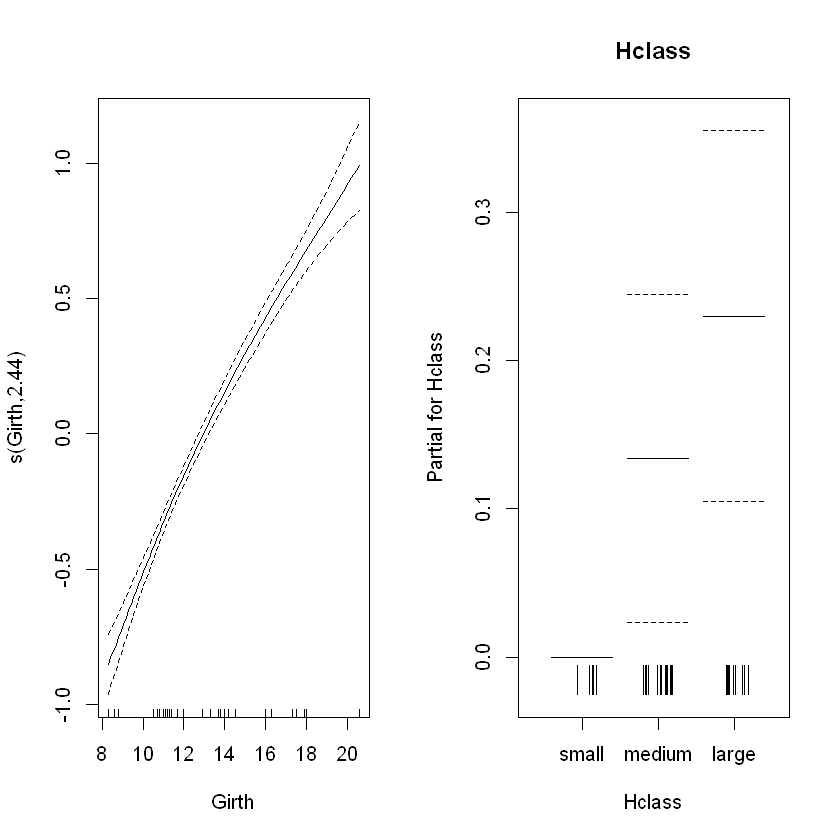

In [52]:
ct7 <- gam(Volume ~ Hclass + s(Girth), family=Gamma(link=log), data=trees)
par(mfrow=c(1, 2)); plot(ct7, all.terms=TRUE)

In [53]:
anova(ct7)


Family: Gamma 
Link function: log 

Formula:
Volume ~ Hclass + s(Girth)

Parametric Terms:
       df     F p-value
Hclass  2 6.802 0.00428

Approximate significance of smooth terms:
           edf Ref.df     F p-value
s(Girth) 2.444  3.076 152.7  <2e-16

clearly there is quite strong evidence that both height and girth matter. Similarly, an approximate AID value can be obtained for the model:

In [54]:
AIC(ct7)

[1] 154.9267

In [55]:
summary(ct7)


Family: Gamma 
Link function: log 

Formula:
Volume ~ Hclass + s(Girth)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.12722    0.04899  63.836   <2e-16 ***
Hclassmedium  0.13415    0.05534   2.424   0.0227 *  
Hclasslarge   0.23000    0.06253   3.678   0.0011 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
           edf Ref.df     F p-value    
s(Girth) 2.444  3.076 152.7  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.967   Deviance explained = 96.9%
GCV = 0.012075  Scale est. = 0.010192  n = 31

Notice that the significance of individual parameters of rht parametric terms is given, rather than whole term significance. Other measures of fit are also reported, such as the adjusted r^2 and percentage deviance explained, along with the GCV score, an estimate of the scale parameter of the model, and the number of data fitted.